In [223]:
# Importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import seaborn as sns
from scipy import stats
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [224]:
df = pd.read_csv("Advertising.csv")
df.drop("Unnamed: 0", axis=1,inplace=True)

In [225]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
TV           200 non-null float64
radio        200 non-null float64
newspaper    200 non-null float64
sales        200 non-null float64
dtypes: float64(4)
memory usage: 6.4 KB


In [226]:
X=df.drop(['sales'],axis=1)
Y=df.sales
lr = LinearRegression()
model=lr.fit(X,Y)
y_pred = model.predict(X)
print("R-squared: {0}".format(metrics.r2_score(Y,y_pred)))

R-squared: 0.8972106381789522


Text(0, 0.5, 'Residuals')

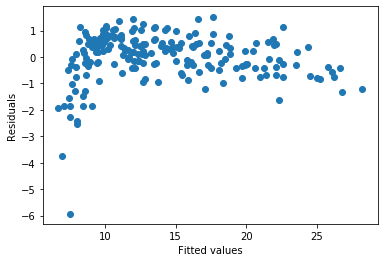

In [227]:
plt.scatter(ypred, (Y-ypred))
plt.xlabel("Fitted values")
plt.ylabel("Residuals")

**Assumption 1:**<br>
The Dependent variable and Independent variable must have a linear relationship.

**How to Check?**<br>
A simple pairplot of the dataframe can help us see if the Independent variables exibit linear relationship with the Dependent Variable.

**How to Fix?**<br>
To fix non-linearity, one can either do log transformation of the Independent variable log(X) or other non-linear transformations like √X or X^2.

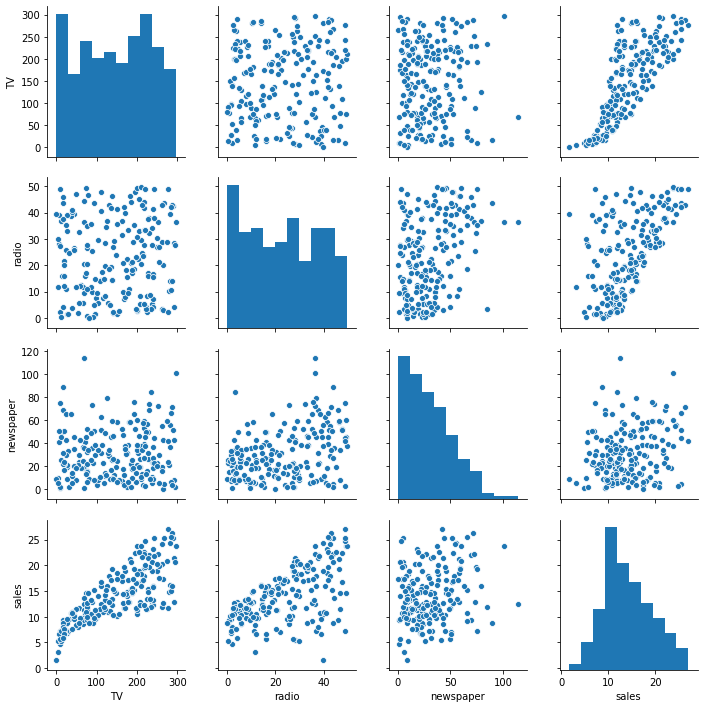

In [228]:
sns.pairplot(df)

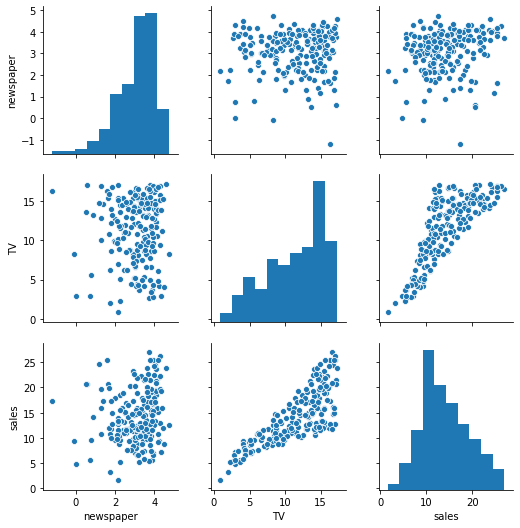

In [229]:
df_linear = df.copy(deep=True)
df_linear.newspaper = np.log(df_linear.newspaper)
df_linear.TV = np.sqrt(df_linear.TV)
sns.pairplot(df_linear[['newspaper','TV','sales']])

By Performing a log transformation of newspaper variable and square root of TV, we can see a linear relationship between sales and TV. And also, distribution of newspaper is more closer to that of a normal distribution.

**Assumption 2:**<br>
No Autocorrelation in residuals.

**How to Check?**<br>
Use Durbin-Watson Test. <br>DW = 2 would be the ideal case here (no autocorrelation) <br>0 < DW < 2 -> positive autocorrelation <br> 2 < DW < 4 -> negative autocorrelation<br>
statsmodels' linear regression summary gives us the DW value amongst other useful insights.

**How to Fix?**<br>
* Add a column thats lagged with respect to the Independent variable
* Center the Variable (Subtract all values in the column by its mean).

In [230]:
X=df.drop(['sales'],axis=1)
Y=df.sales
model = smf.ols(formula = 'sales ~ np.sqrt(TV) + radio + np.log(newspaper)',  data=df)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     854.4
Date:                Sun, 27 Oct 2019   Prob (F-statistic):          2.99e-112
Time:                        20:37:28   Log-Likelihood:                -349.23
No. Observations:                 200   AIC:                             706.5
Df Residuals:                     196   BIC:                             719.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -1.5565      0.42

The DW (Durbin-Watson) value is 2.084 which seems to be very close to the ideal case.

**Assumption 3:**<br>
No Heteroskedasticity.

**How to Check?**<br>
Residual vs Fitted values plot can tell if Heteroskedasticity is present or not.<br>If the plot shows a funnel shape pattern, then we say that Heteroskedasticity is present.<br>

**How to fix?**<br>
We could do a non linear transformation of the dependent variable such as log(Y) or √Y. Also, you can use weighted least square method to tackle heteroskedasticity.

Text(0, 0.5, 'Residuals')

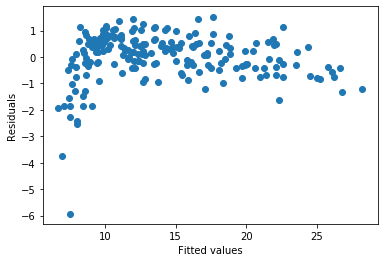

In [231]:
plt.scatter(ypred, (Y-ypred))
plt.xlabel("Fitted values")
plt.ylabel("Residuals")

We dont see a funnel like pattern here, so no heteroskedacity

**Assumption 4:**<br>
No Perfect Multicollinearity.

**How to Check?**<br>
In case of very less variables, one could use heatmap, but that isn't so feasible in case of large number of columns.<br>
Another common way to check would be by calculating VIF (Variance Inflation Factor) values.<br> If VIF=1, Very Less Multicollinearity<br>VIF<5, Moderate Multicollinearity<br>VIF>5 , Extreme Multicollinearity (This is what we have to avoid)

**How to fix?**<br>
The Variables with high Multicollinearity can be removed altogether, or if you can find out which 2 or more variables have high correlation with each other, you could simply merge these variables into one. Make sure that VIF < 5.

In [232]:
# Function to calculate VIF
def calculate_vif(data):
    vif_df = pd.DataFrame(columns = ['Var', 'Vif'])
    x_var_names = data.columns
    for i in range(0, x_var_names.shape[0]):
        y = data[x_var_names[i]]
        x = data[x_var_names.drop([x_var_names[i]])]
        r_squared = sm.OLS(y,x).fit().rsquared
        vif = round(1/(1-r_squared),2)
        vif_df.loc[i] = [x_var_names[i], vif]
    return vif_df.sort_values(by = 'Vif', axis = 0, ascending=False, inplace=False)

In [233]:
X=df.drop(['sales'],axis=1)
calculate_vif(X)

,Var,Vif
1,radio,3.29
2,newspaper,3.06
0,TV,2.49


Independent Variables seem to have Moderate VIF. So, no action needed here.

**Assumption 5:**<br>
Residuals must be normally distributed.

**How to Check?**<br>
Use Distribution plot on the residuals and see if it is normally distributed.

**How to Fix?**<br>
If the Resiudals are not normally distributed, non–linear transformation of the dependent or independent variables can be tried.


 mu = 14.02 and sigma = 5.20



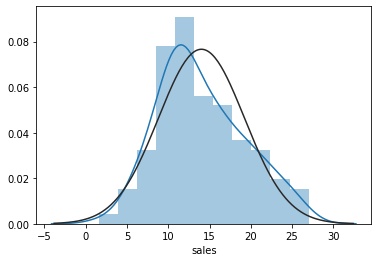

In [234]:
sns.distplot(df['sales'] , fit=norm);
(mu, sigma) = norm.fit(df['sales'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

For the most part we can see that the 'sales' variable is normally distribution with a slight skew.<br> Another way how we can determine the same is using Q-Q Plot (Quantile-Quantile)

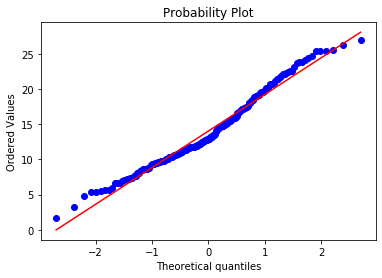

In [235]:
fig = plt.figure()
res = stats.probplot(df['sales'], plot=plt)
plt.show()

The Quantiles are following a straight line for the most part, So we can infer that the distribution is normal.

### Conclusion ###
We have now validated that all the Assumptions of Linear Regression are taken care of and we can safely say that it will deliver good results.<br> So, basically if your Linear Regression model is giving sub-par results, make sure that these Assumptions are validated and if you have fixed your data to fit these assumptions, then your model will surely see improvements.